In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import datetime

from kiblib.utils.db import DbConn
from kiblib.utils.code2libelle import Code2Libelle
from kiblib.adherent import Adherent

In [181]:
class StatActivite():
    def __init__(self, **kwargs):
        if 'db_conn' in kwargs:
            self.db_conn = kwargs.get('db_conn')
        else:
            raise Exception("Manque l'argument 'db_conn'.")
            
        if 'query' in kwargs:
            self.query = kwargs.get('query')
        else:
            raise Exception("Manque l'argument 'query'.")
            
        if 'c2l' in kwargs:
            self.c2l = kwargs.get('c2l')
        
        if 'is_hour' in kwargs:
            self.is_hour = kwargs.get('is_hour')
        else:
            self.is_hour = True
        
        if 'dates' in kwargs:
            dates_str = kwargs.get('dates')
            self.dates = [datetime.date.fromisoformat(date_str) for date_str in dates_str]
        else:
            self.dates = None
            
        if 'semaines' in kwargs:
            self.semaines = kwargs.get('semaines')
        else:
            self.semaines = None
            
        self.df = pd.read_sql(self.query, con=self.db_conn)
        
        if 'date_heure' not in self.df:
            raise Exception("Les données ne comportent pas de colonne 'date_heure'.")
        
        self.df['date_heure'] = pd.to_datetime(self.df['date_heure'])
        self.df['annee'] = self.df['date_heure'].dt.year
        self.df['date'] = self.df['date_heure'].dt.date
        self.df['semaine'] = self.df['date_heure'].dt.year.astype(str) + "-" + self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['semaine_simple'] = self.df['date_heure'].dt.isocalendar().week
        self.df['jour_semaine'] = self.df['date_heure'].dt.weekday

        if self.is_hour:
            self.df['heure'] = self.df['date_heure'].dt.hour
            self.df = self.df[(self.df['heure'] >= 9) & (self.df['heure'] < 19)]
            self.df = self.df.drop(self.df[(self.df['heure'] > 17) & (self.df['jour_semaine'] == 6)].index)
            self.df = self.df.drop(self.df[(self.df['heure'] < 14) & (self.df['jour_semaine'] == 6)].index)
        
        if self.semaines is not None:
            self.df = self.df[self.df['semaine'].isin(self.semaines)]
        
        if self.dates is not None:
            self.df = self.df[self.df['date'].isin(self.dates)]
        
        if 'nombre' not in self.df:
            self.df['nombre'] = 1
            
    def get_df_activiteHebdomadaire_parJourHeure(self):
        jours = {0: "lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"}
        if self.is_hour:
            self.df_activiteHebdomadaire_parJourHeure_ = self.df.groupby(['semaine', 'jour_semaine', 'heure'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJourHeure = self.df_activiteHebdomadaire_parJourHeure_.groupby(['jour_semaine', 'heure'])['nombre'].median().to_frame().reset_index()
            self.df_activiteHebdomadaire_parHeure_colonneJour = pd.pivot_table(self.df_activiteHebdomadaire_parJourHeure, values='nombre', index='heure', columns='jour_semaine', aggfunc='mean')
            for j in self.df_activiteHebdomadaire_parHeure_colonneJour.columns:
                self.df_activiteHebdomadaire_parHeure_colonneJour = self.df_activiteHebdomadaire_parHeure_colonneJour.rename(columns={ j: jours[j] })
        else:
            self.df_activiteHebdomadaire_parJour_ = self.df.groupby(['semaine', 'jour_semaine'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJour = self.df_activiteHebdomadaire_parJour_.groupby(['jour_semaine'])['nombre'].median().to_frame().reset_index()
            self.df_activiteHebdomadaire_colonneJour = pd.pivot_table(self.df_activiteHebdomadaire_parJour, values='nombre', columns='jour_semaine', aggfunc='mean')
            for j in self.df_activiteHebdomadaire_colonneJour.columns:
                self.df_activiteHebdomadaire_colonneJour = self.df_activiteHebdomadaire_colonneJour.rename(columns={ j: jours[j] })
        
        
         
    def get_df_activiteJourSemaine_parPeriode(self, jourSemaine=6): #par défaut, le dimanche
        self.df_jourSemaine = self.df[self.df['jour_semaine'] == jourSemaine]
        self.df_activiteJourSemaine_parPeriode = self.df_jourSemaine.groupby(['date'])['nombre'].sum().to_frame().reset_index()
        if self.is_hour:
            self.df_activiteJourSemaineHeure_parPeriode_ = self.df_jourSemaine.groupby(['semaine', 'date', 'heure'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteJourSemaineHeure_parPeriode = self.df_activiteJourSemaineHeure_parPeriode_.groupby(['date', 'heure'])['nombre'].median().to_frame().reset_index()
        if 'usager' in self.df_jourSemaine:
            self.df_activiteJourSemaineUsagers_parPeriode = self.df_jourSemaine.groupby(['date'])['usager'].nunique().to_frame().reset_index()
        if 'location' in self.df:
            self.df_jourSemaine = self.df_jourSemaine[self.df_jourSemaine['location'].isin(['MED0C', 'MED1A', 'MED2A', 'MED3A'])]
            self.df_jourSemaine['localisation'] = self.df_jourSemaine['location'].apply(
                lambda x: self.c2l['localisation'][x]['lib']
                if x in self.c2l['localisation'] else np.nan)
            self.df_activiteHebdomadaire_parJourLocalisation_ = self.df_jourSemaine.groupby(['semaine', 'date', 'localisation'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJourLocalisation = self.df_activiteHebdomadaire_parJourLocalisation_.groupby(['date', 'localisation'])['nombre'].median().to_frame().reset_index()

In [182]:
db_conn = DbConn().create_engine()

c2l = Code2Libelle(db_conn)
c2l.get_val()
c2l = c2l.dict_codes_lib

# Activité le dimanche

## Entrées

In [183]:
query = """
SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE DATE(datetime) BETWEEN '2022-09-05' AND '2022-10-17'
"""
entrees = StatActivite(db_conn=db_conn, query=query)
entrees.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
entrees.get_df_activiteHebdomadaire_parJourHeure()

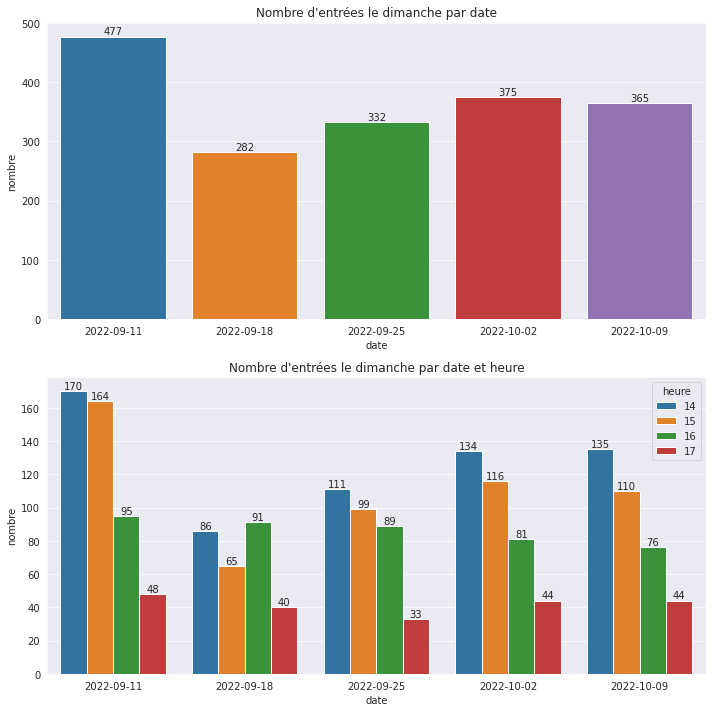

In [186]:
f, ax = plt.subplots(2, figsize=(10, 10))
sns.barplot(data=entrees.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title("Nombre d'entrées le dimanche par date")
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=entrees.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title("Nombre d'entrées le dimanche par date et heure")
for i in ax[1].containers:
    ax[1].bar_label(i,)
f.tight_layout()

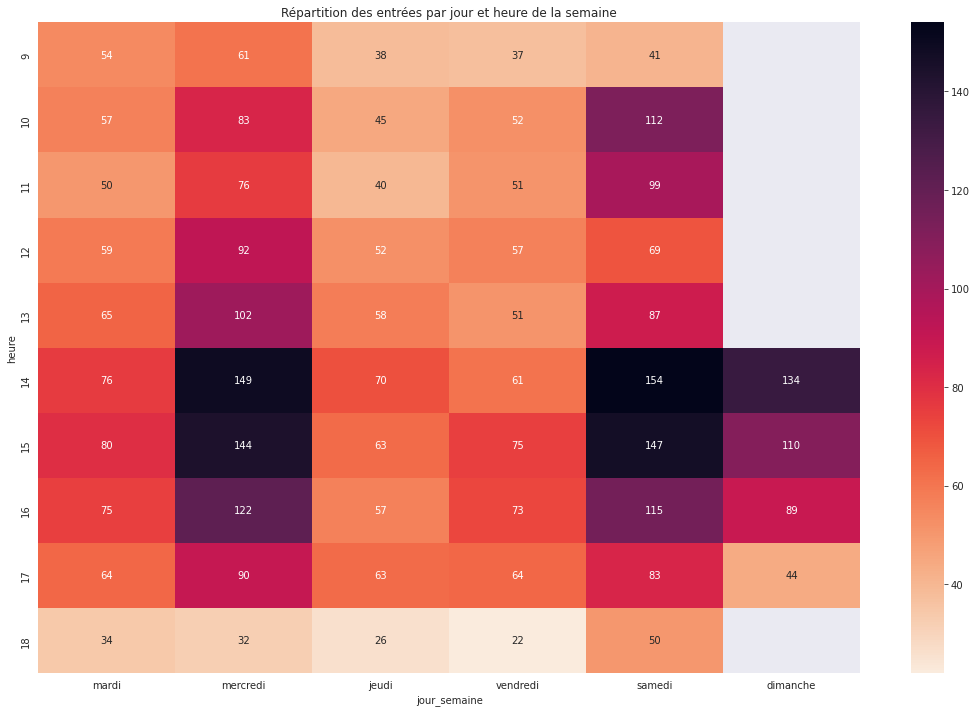

In [187]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(entrees.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des entrées par jour et heure de la semaine")
f.tight_layout()

## Prêts

### Ensemble de la Médiathèque

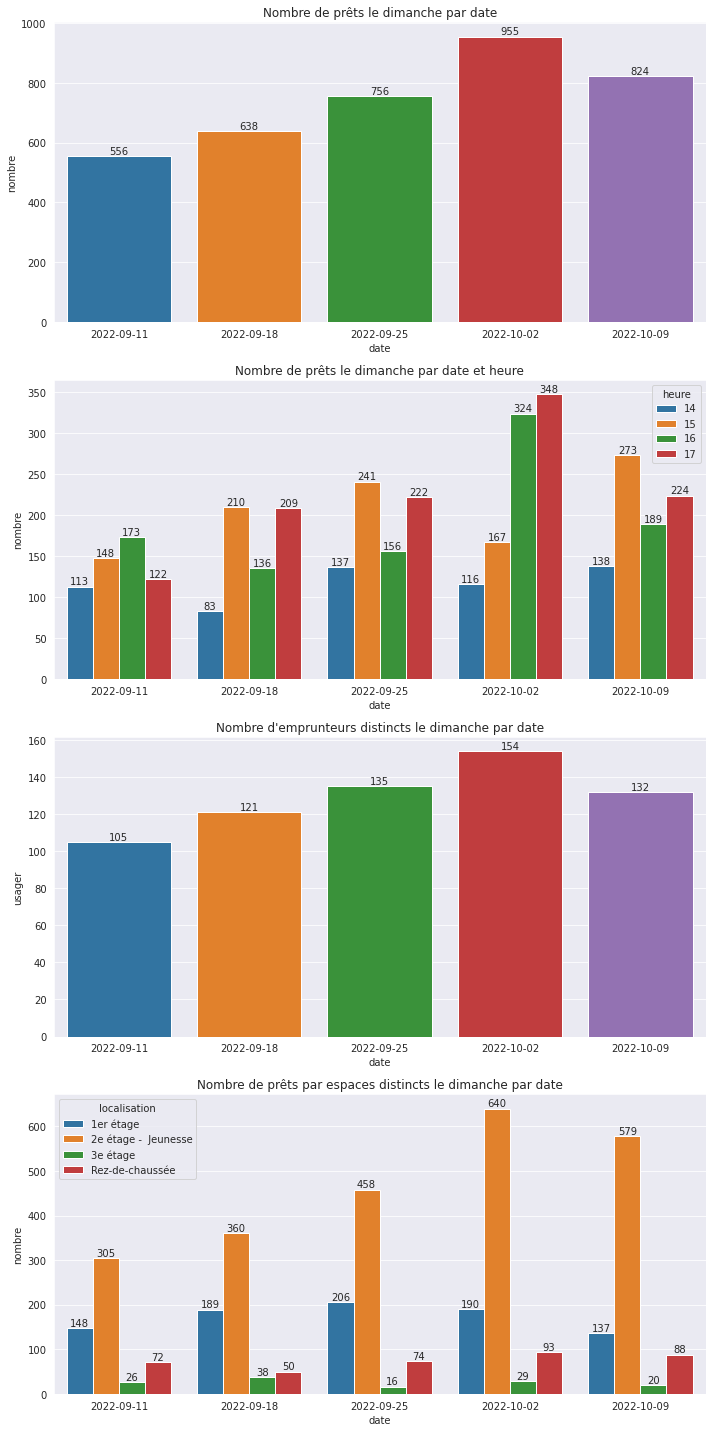

In [188]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location NOT IN ('MED0A', 'BUS1A')
"""
prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
prets.get_df_activiteHebdomadaire_parJourHeure()

f, ax = plt.subplots(4, figsize=(10, 20))
sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
sns.barplot(data=prets.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].set_title("Nombre de prêts par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()

In [172]:
prets.df_activiteHebdomadaire_parJourLocalisation

,date,localisation,nombre
0,2022-09-06,1er étage,459.0
1,2022-09-06,2e étage - Jeunesse,229.0
2,2022-09-06,3e étage,85.0
3,2022-09-06,Mag Bibliothèque professionnelle,3.0
4,2022-09-06,Mag Pôle adultes °8,2.0
...,...,...,...
200,2022-10-14,1er étage,267.0
201,2022-10-14,2e étage - Jeunesse,366.0
202,2022-10-14,3e étage,54.0
203,2022-10-14,Mag Pôle adultes °8,2.0


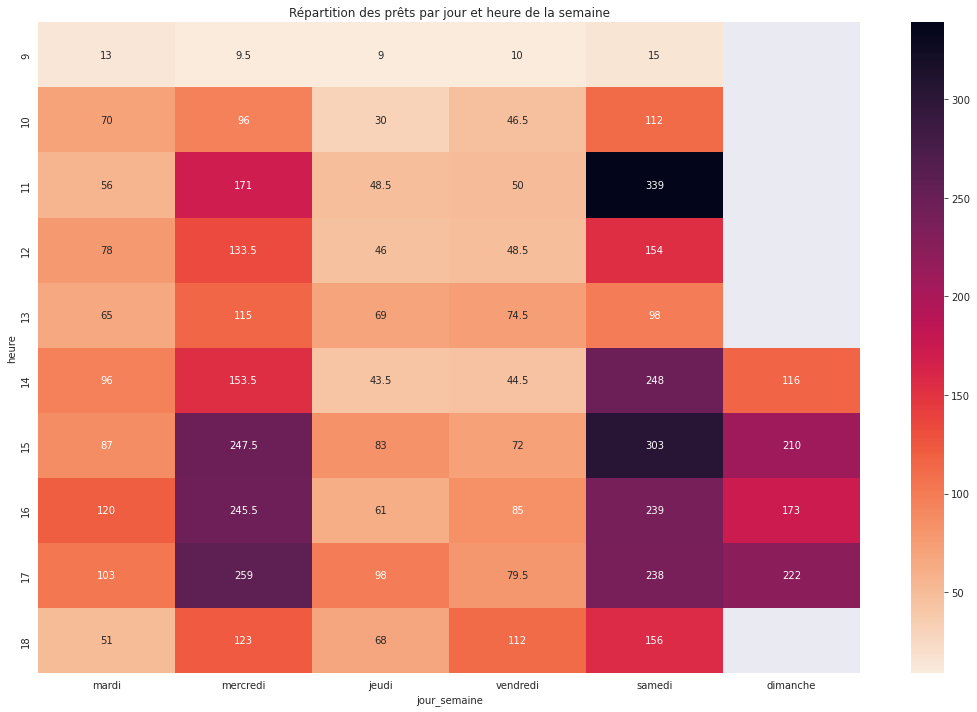

In [115]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

## Rez-de-chaussée

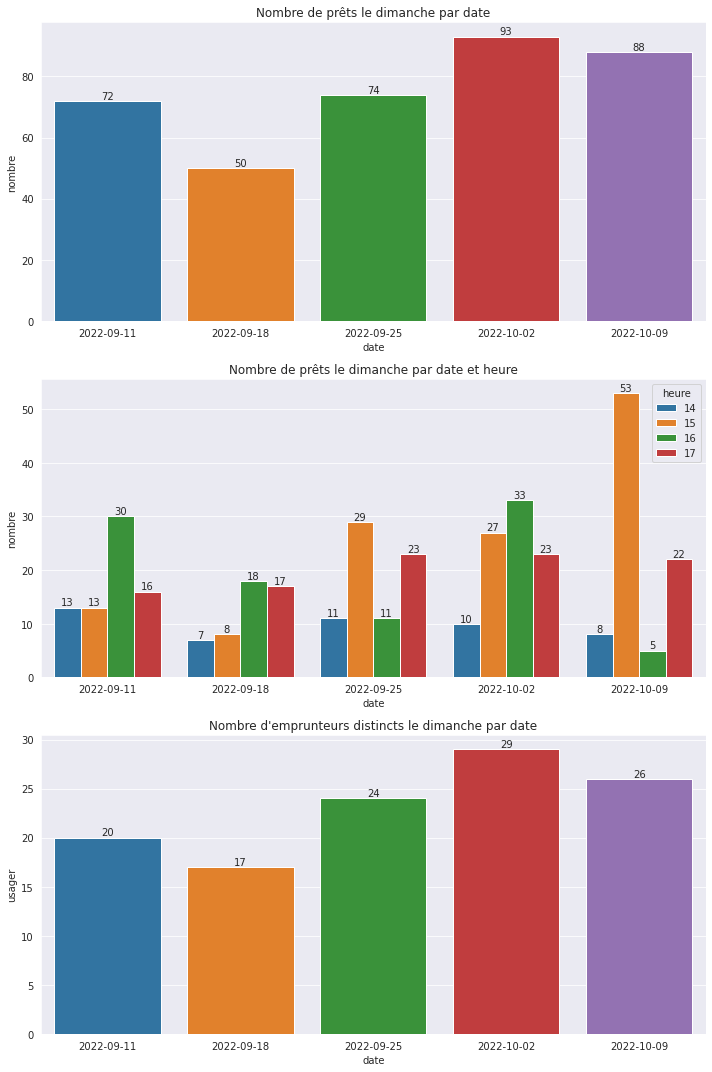

In [127]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location = 'MED0C'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
prets.get_df_activiteHebdomadaire_parJourHeure()

f, ax = plt.subplots(3, figsize=(10, 15))
sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()

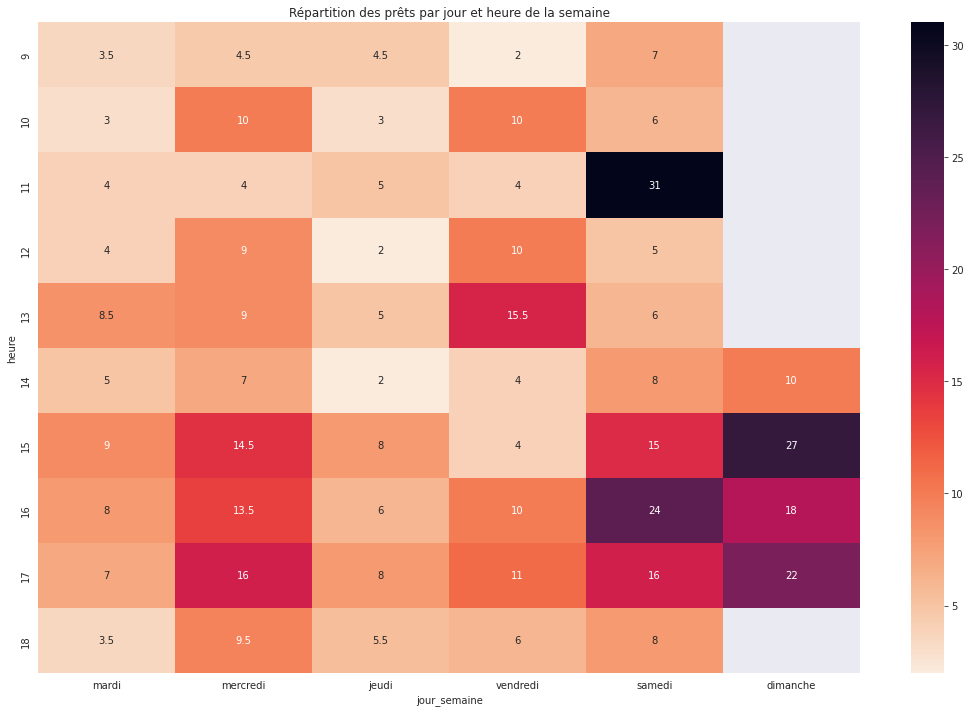

In [128]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### LAC

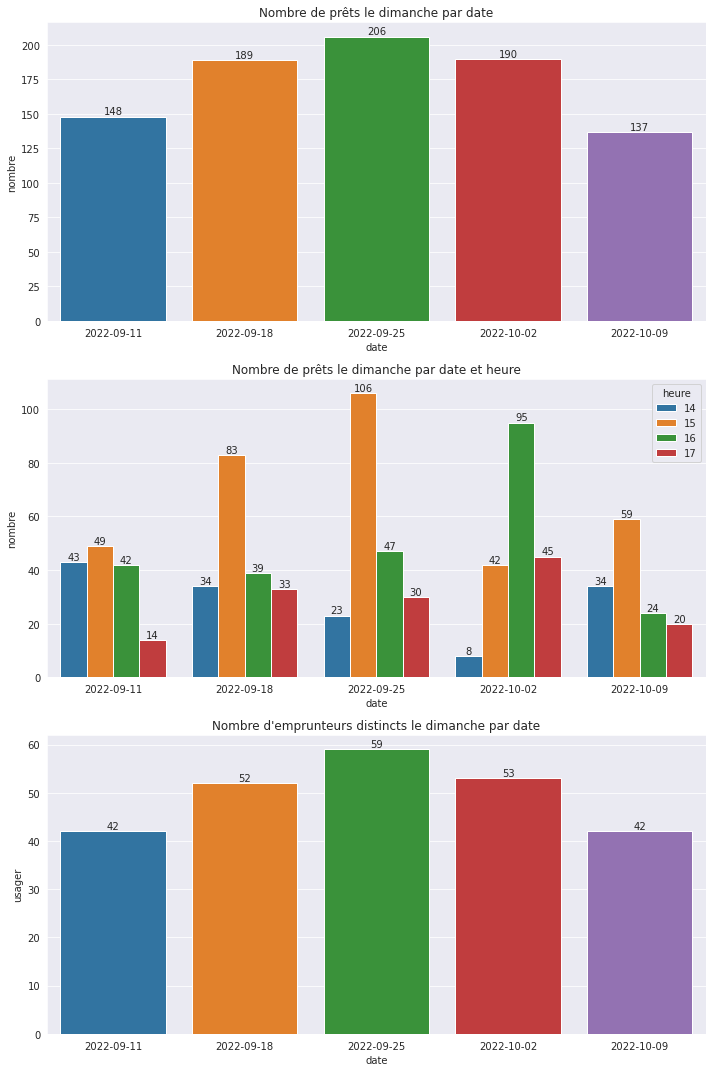

In [129]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location = 'MED1A'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
prets.get_df_activiteHebdomadaire_parJourHeure()

f, ax = plt.subplots(3, figsize=(10, 15))
sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()

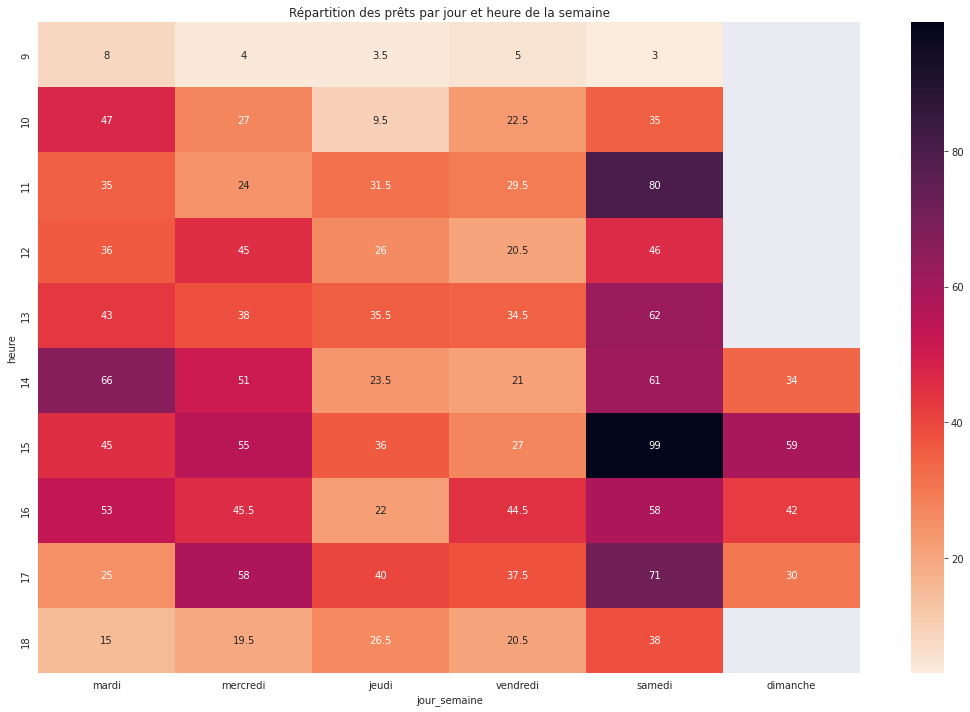

In [130]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### Jeunesse

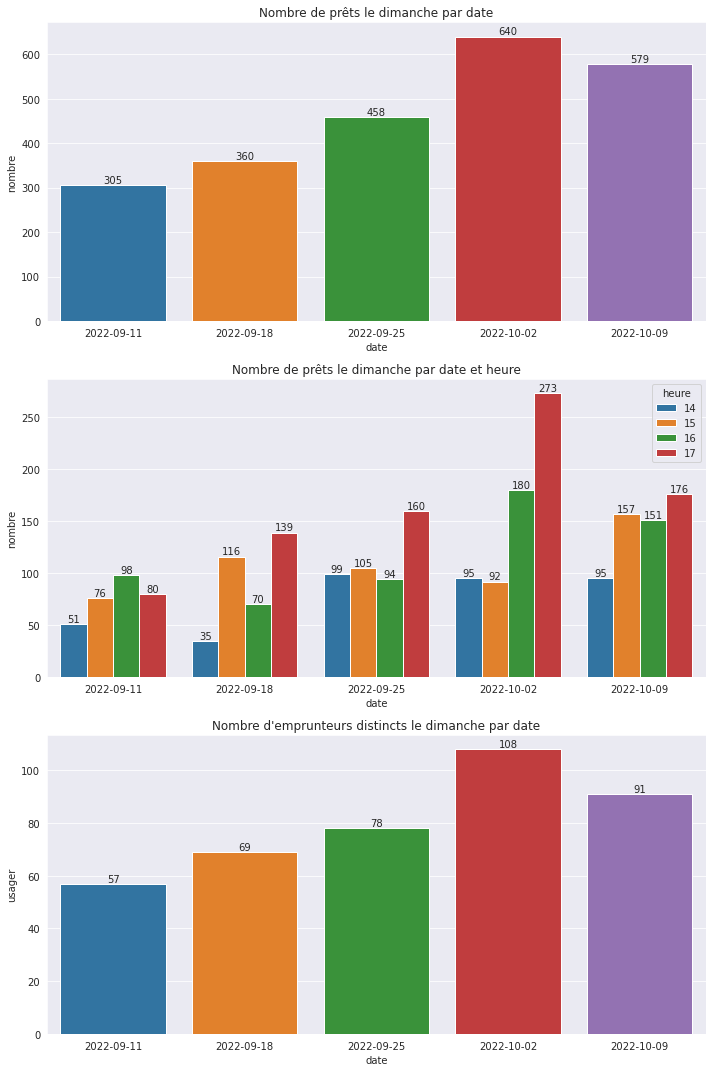

In [138]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location = 'MED2A'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
prets.get_df_activiteHebdomadaire_parJourHeure()

f, ax = plt.subplots(3, figsize=(10, 15))
sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()

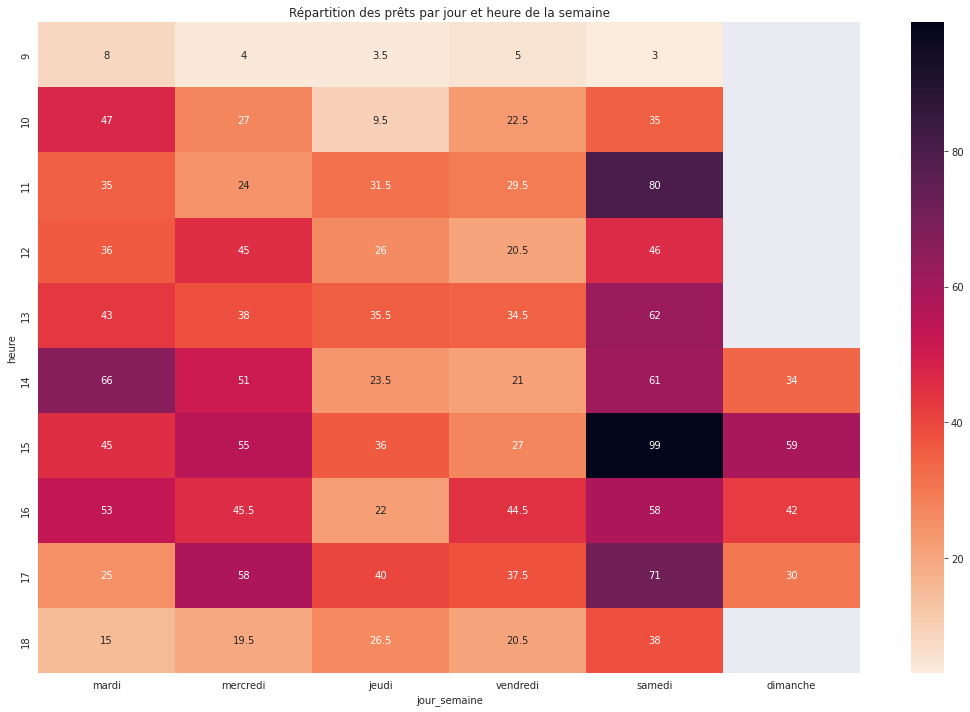

In [132]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### Phare

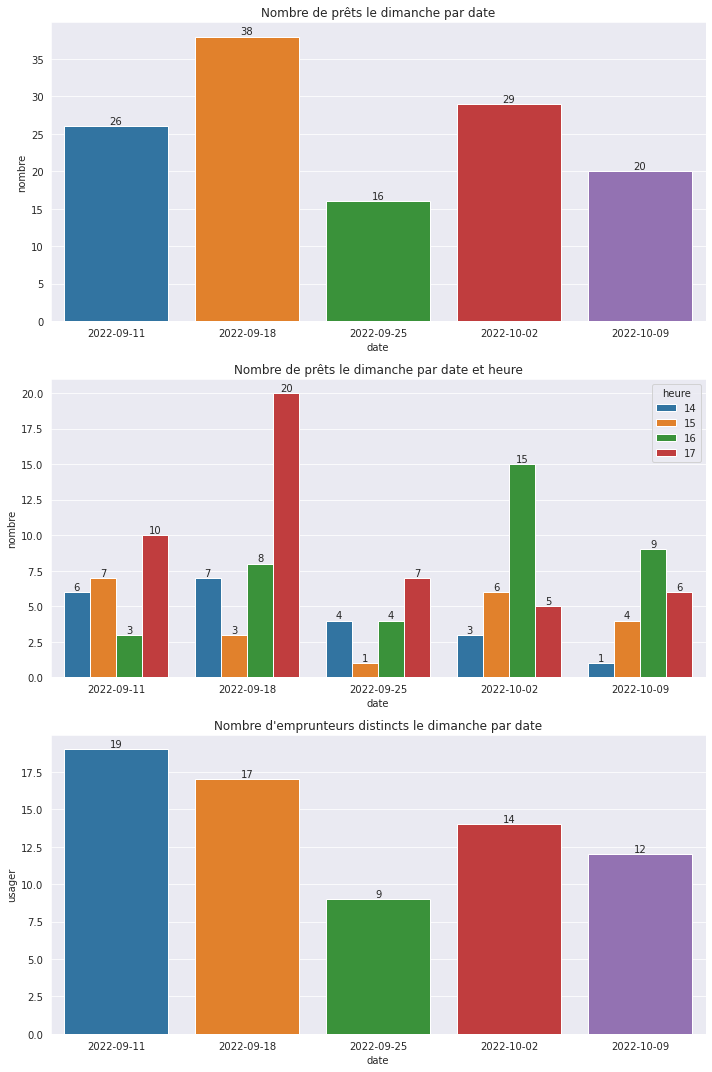

In [139]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location = 'MED3A'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
prets.get_df_activiteHebdomadaire_parJourHeure()

f, ax = plt.subplots(3, figsize=(10, 15))
sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()

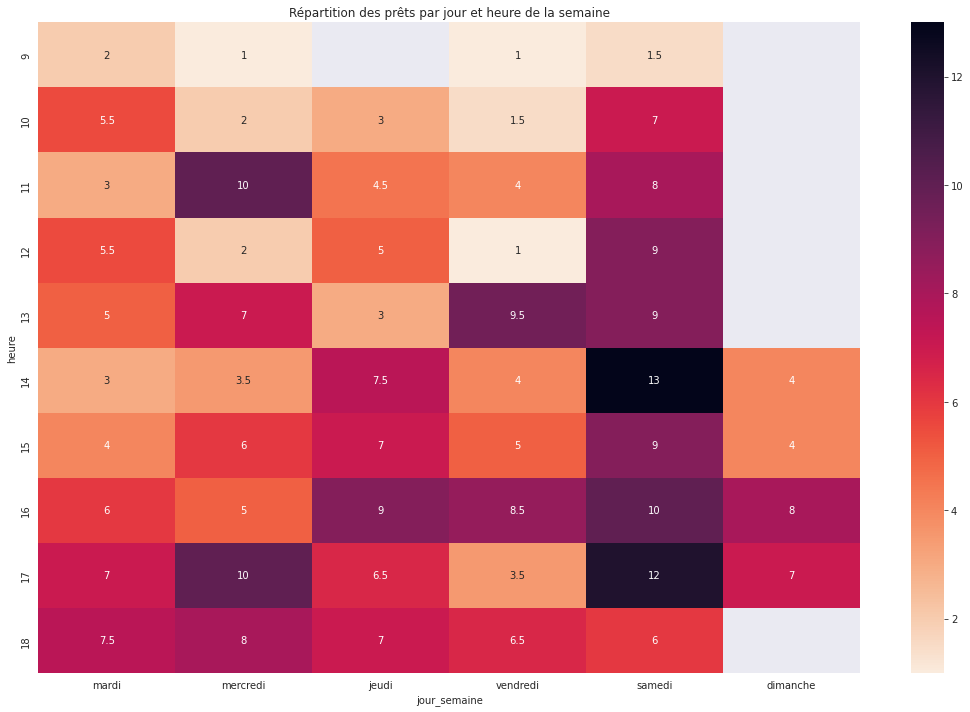

In [140]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

## Retours

In [120]:
query = """
SELECT returndate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(returndate) BETWEEN '2022-09-05' AND '2022-10-17'
AND location NOT IN ('MED0A', 'BUS1A')
"""
retours = StatActivite(db_conn=db_conn, query=query)
retours.get_df_activiteJourSemaine_parPeriode(jourSemaine=6)
retours.get_df_activiteHebdomadaire_parJourHeure()

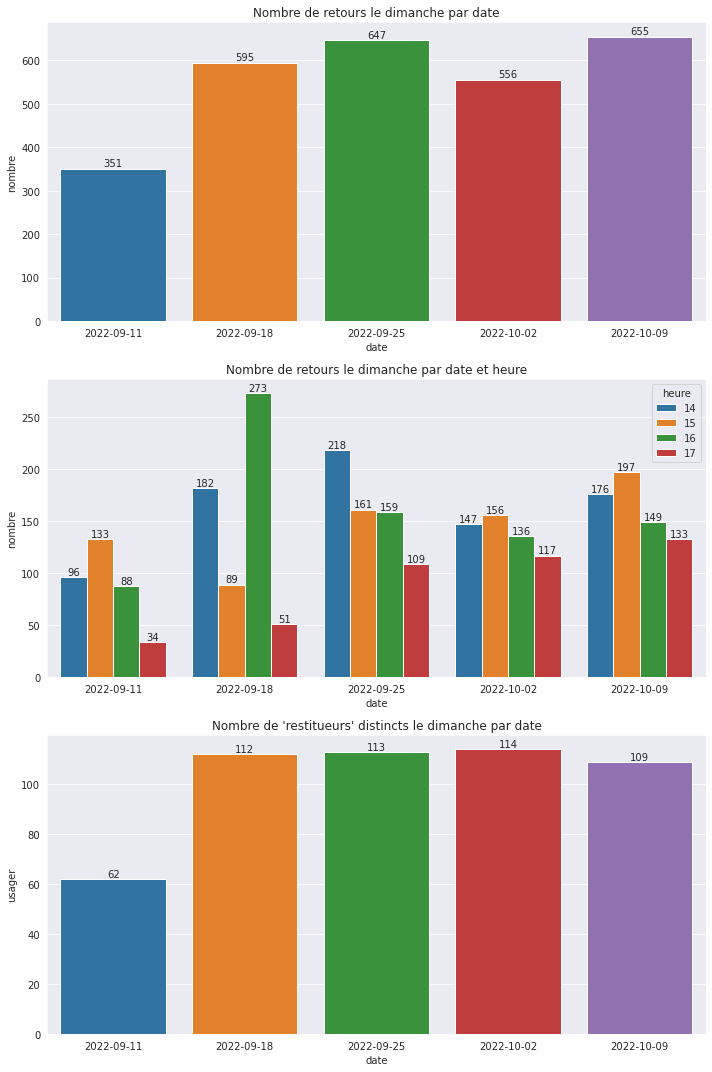

In [121]:
f, ax = plt.subplots(3, figsize=(10, 15))
sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].set_title("Nombre de 'restitueurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()

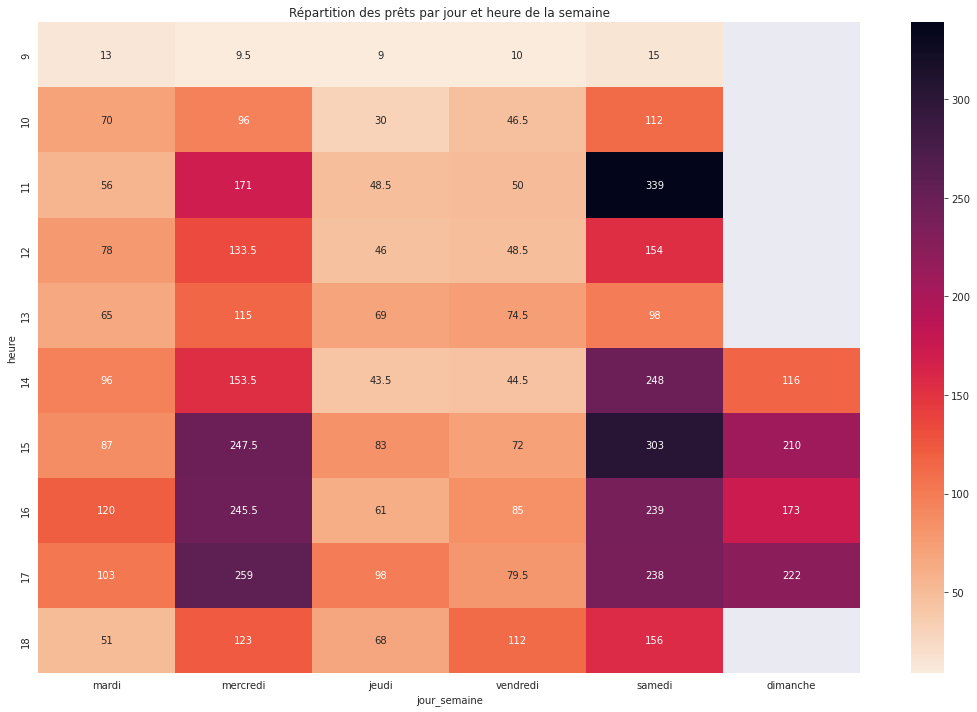

In [122]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()